In [1]:
from collections import defaultdict
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import re

In [2]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

In [3]:
RUN_DIR = "/lfs/1/keshav2/benchmarking/benchmark_output/runs"

In [4]:
def get_per_instance_runtimes(per_instance_metrics):
    runtimes = []
    for values in per_instance_metrics:
        for metric in values["stats"]:
            if metric["name"]["name"] == "inference_runtime":
                assert metric["count"] == 1
                runtimes.append(metric["sum"])
    return runtimes

In [5]:
def get_data(api):
    run_dir = os.path.join(RUN_DIR, f"{api}_load_test") 
    data = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    metric_dirs = os.listdir(run_dir)
    tokenizer = "huggingface_gpt2" if api != "ai21" else "ai21_j1"
    pattern = (
        f"synthetic_efficiency:tokenizer={tokenizer},"
        f"num_prompt_tokens=(\d+),"
        f"num_output_tokens=(\d+),"
        f"random=(.*),"
        f"model=(.*)"
    )
    for metric_dir in os.listdir(run_dir):
        match = re.match(pattern, metric_dir)
        if match is None:
            continue
        num_input_tokens = int(match.group(1))
        num_output_tokens = int(match.group(2))
        random = match.group(3)
        num_threads = int(random.split("=")[-1])
        model = match.group(4).replace("_", "/")
        path = os.path.join(run_dir, metric_dir, "per_instance_stats.json")
        if os.path.exists(path):
            with open(path, "r") as f:
                per_instance_metrics = json.load(f)
                per_instance_runtimes = get_per_instance_runtimes(per_instance_metrics)
        else:
            per_instance_runtimes = [None]
        data[model][num_input_tokens][num_output_tokens][num_threads] = per_instance_runtimes
    return data

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


[1, 2, 4, 8, 16, 32] [0.4243917465209961, 0.18036127090454102, 0.20929479598999023, 0.19245266914367676, 0.19515109062194824, 0.19509100914001465]
[1, 2, 4, 8, 16, 32] [0.427518367767334, 0.22944116592407227, 0.2764132022857666, 0.24536919593811035, 0.23142719268798828, 0.2283027172088623]
[1, 2, 4, 8, 16, 32] [0.42184877395629883, 0.3177506923675537, 0.31700801849365234, 0.2569437026977539, 0.3164052963256836, 0.30861449241638184]
[1, 2, 4, 8, 16, 32] [0.445819616317749, 0.5563812255859375, 0.3756284713745117, 0.7957186698913574, 0.37067198753356934, 0.4502096176147461]
[1, 2, 4, 8, 16, 32] [0.5831568241119385, 0.5986654758453369, 0.7127294540405273, 0.7491781711578369, 0.7869431972503662, 0.7576258182525635]
[1, 2, 4, 8, 16, 32] [1.2312614917755127, 1.0556490421295166, 1.1344842910766602, 2.1221232414245605, 1.1222584247589111, 1.1146349906921387]
[1, 2, 4, 8, 16, 32] [2.337799072265625, 2.1771037578582764, 2.352252721786499, 2.3299155235290527, 3.093600273132324, 2.5373613834381104]

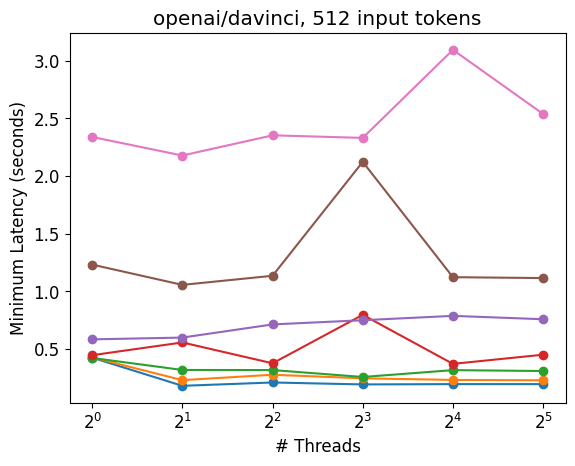

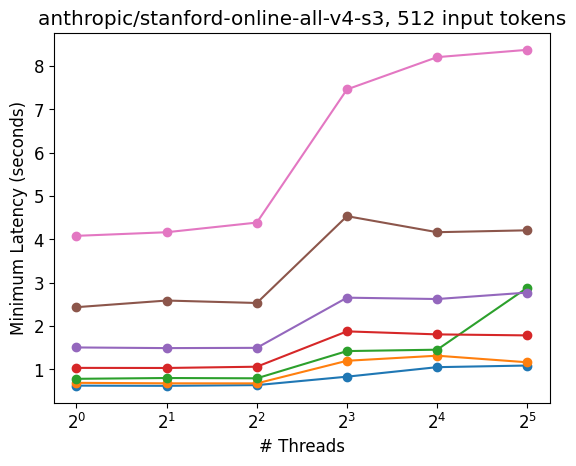

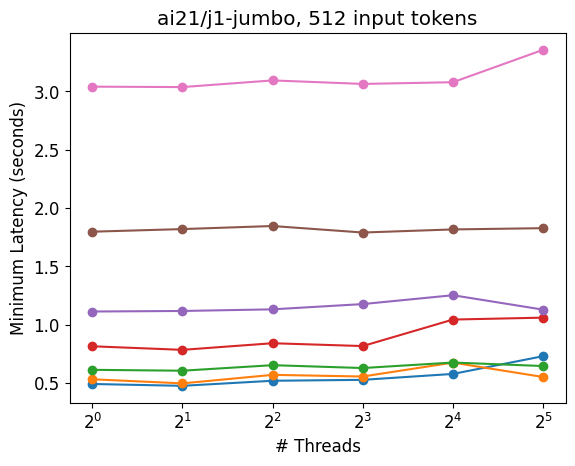

In [6]:
for api in ["openai", "anthropic", "ai21"]:
    data = get_data(api)
    for model in data:
        for num_input_tokens in data[model]:
            plt.figure()
            for num_output_tokens in sorted(data[model][num_input_tokens].keys()):
                x = sorted(data[model][num_input_tokens][num_output_tokens].keys())
                y = [np.min(data[model][num_input_tokens][num_output_tokens][num_threads]) for num_threads in x]
                print(x, y)
                plt.plot(x, y, label=f"{num_output_tokens} output token(s)", marker="o")
            # plt.legend()
            plt.xscale("log", base=2)
            plt.xlabel("# Threads")
            plt.ylabel("Minimum Latency (seconds)")
            plt.title(f"{model}, {num_input_tokens} input tokens")